# Regressão em Dados de Seguros

Este notebook apresenta um exemplo prático de regressão aplicada a um conjunto de dados de seguros médicos. O objetivo é mostrar, de forma didática, como preparar os dados, construir pipelines de pré-processamento e treinar modelos preditivos usando o scikit-learn.

**Conteúdo abordado:**
- Análise exploratória dos dados
- Separação em treino e teste
- Pré-processamento com pipelines
- Treinamento de modelos de regressão
- Avaliação de desempenho
- Visualização dos resultados

---

## Análise Exploratória Inicial

Vamos iniciar carregando o dataset de **seguros** em um *DataFrame* do **pandas**. Dentre os objetivos da análise exploratória inicial estáo:

- Verificar o conteúdo do dataset  
- Identificar o formato das *features*  
- Contar o número de instâncias  
- Avaliar a existência de dados faltantes  

### Verificação de consistência dos dados
Com os métodos `head` e `info` observamos que não há dados faltantes. Além disso, o dataset possui **6 features**, sendo **3 numéricos** (`age`, `bmi`, `children`) e **3 categóricos** (`sex`, `smoker`, `region`) , além do **target**, representado por `charges`.

Por meio do método `describe`, obtemos uma **descrição estatística inicial** 
das variáveis numéricas, incluindo métricas como **média** e **desvio padrão**.

### Histogramas e Contagem de Valores
O método `hist` nos dá os histogramas com a distribuição dos valores das variáveis numéricas. Já o método `value_counts` nos fornece a contagem de valores para cada feature categórica.

Essas visualizações nos permitem identificar **padrões gerais**, como simetria ou assimetria, presença de caudas longas e possíveis concentrações de dados em determinados intervalos.
 

In [ ]:
### ANÁLISE EXPLORATÓRIA INICIAL ###

import pandas as pd
import numpy as np

# Importar dados
dataset_path = "titanic/train.csv" # Dados já estão na mesma pasta do notebook
titanic = pd.read_csv(dataset_path) 

# Análise inicial dos dados
print(titanic.head()) # Notar quantidade de features categóricos e númericos
print(titanic.info()) # Notar que há valores faltantes em duas features
print(titanic.describe()) 

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

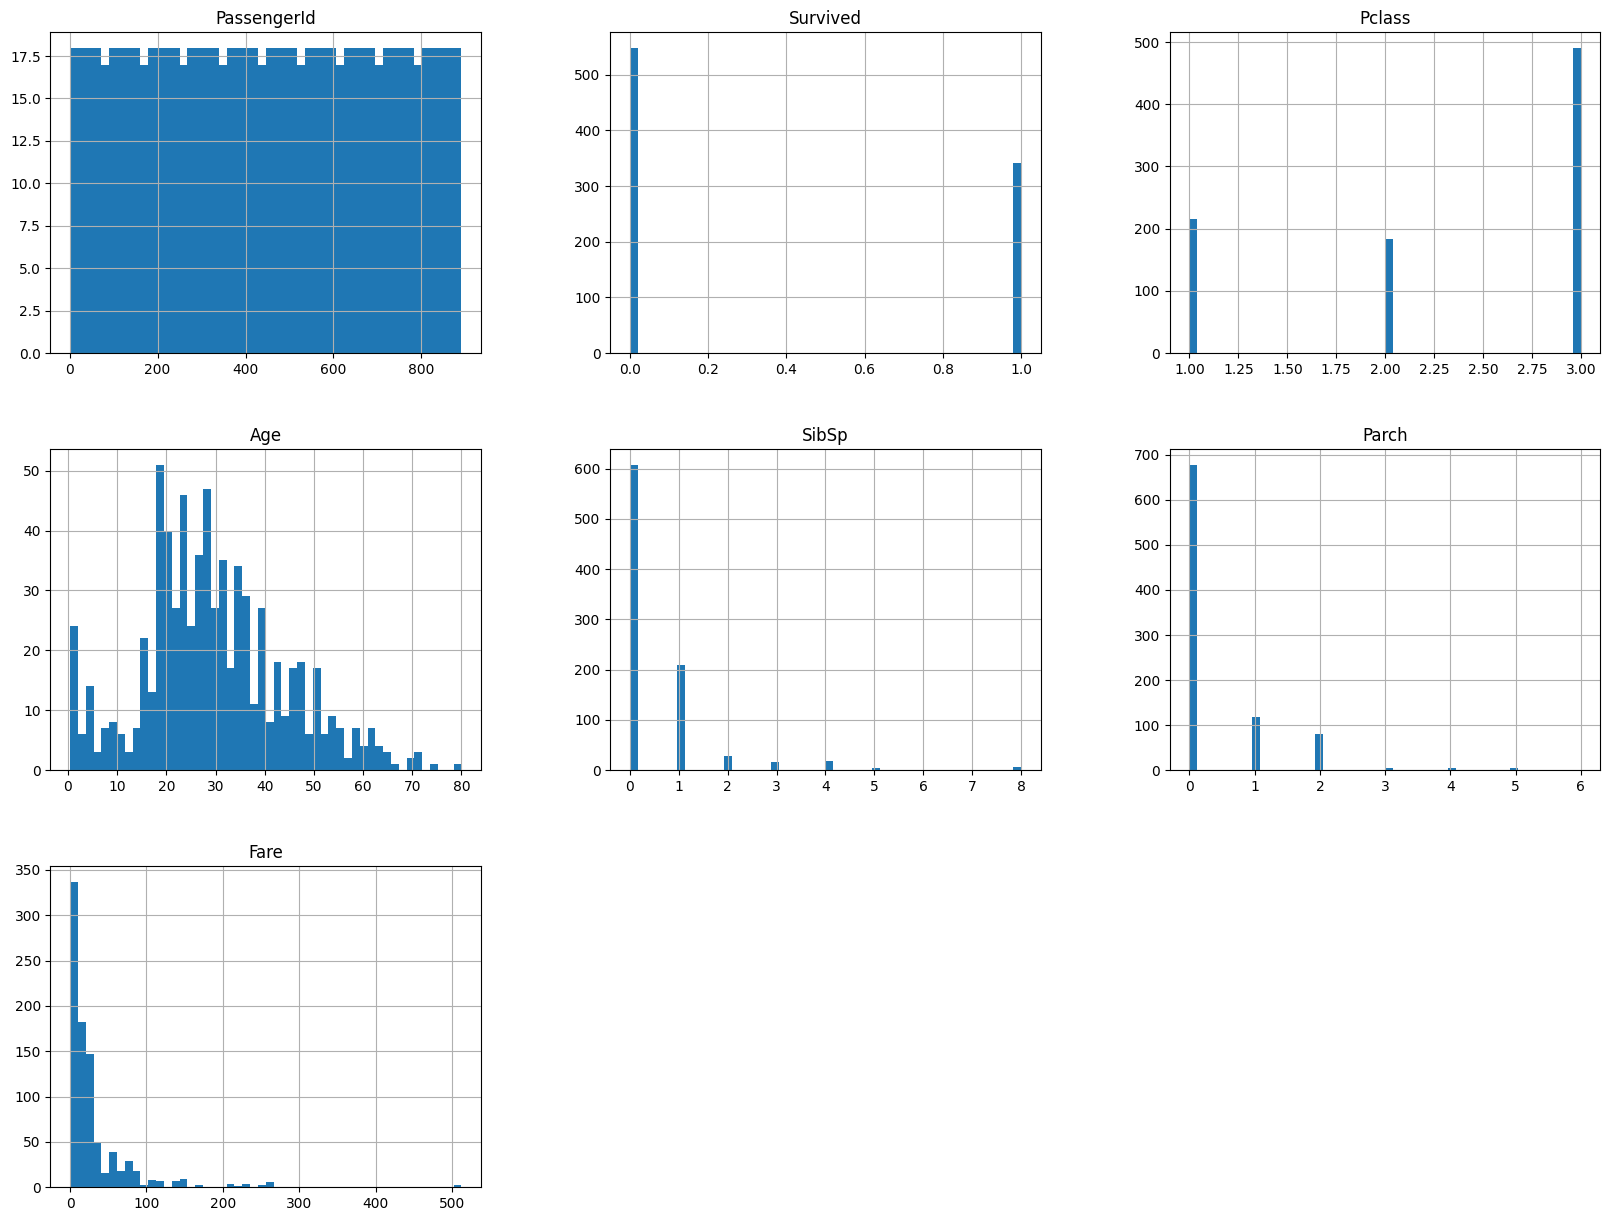

In [100]:
### ANÁLISE EXPLORATÓRIA INICIAL ###

# Visualização inicial dos dados
titanic.hist(bins=50, figsize=(20,15)) # Notar outlier em fare. 
titanic["Cabin"].value_counts() # Mais homens que mulheres.

# Separação Treinamento/Teste

Para avaliar o desempenho do modelo de forma imparcial, é necessário dividir o dataset em dois subconjuntos:

- **Treinamento:** utilizado para ajustar os parâmetros do modelo.  
- **Teste:** utilizado exclusivamente para validar o modelo em dados não vistos.

Utilizamos a função `train_test_split`, definindo uma proporção de 80% dos dados para treinamento e 20% para teste.

Além disso, para cada conjunto, também separamos a matriz de features **X** da coluna de target **y**.

In [21]:
### SEPARAÇÃO TREINAMENTO/TESTE ###

from sklearn.model_selection import train_test_split

titanic_train, titanic_test = train_test_split(titanic, test_size=0.2, random_state=42)
titanic_train.info()

# Separação atributos/labels
titanic_train_X = titanic_train.drop(columns=["Survived"]) # X == Atributos, y == Labels
titanic_train_y = titanic_train["Survived"]

titanic_test_X = titanic_test.drop(columns=["Survived"])
titanic_test_y = titanic_test["Survived"]

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


## Análise Exploratória no Conjunto de Treinamento

Uma vez feita a separação, é possível conduzir uma análise exploratória mais profunda no conjunto de treinamento, sem que haja risco de **vazamento de informação** do conjunto de teste.  

Em nossa análise utilizamos ferramentas como:  
- **Matriz de correlações**, para avaliar relações lineares entre variáveis numéricas.  
- **Scatter plots**, úteis para observar padrões, tendências e possíveis outliers.  
- **Boxplots**, que destacam a dispersão e valores extremos nas variáveis.  
- **Tabelas de contingência**, que permitem examinar a distribuição conjunta de variáveis categóricas.  

O uso dessas técnicas é importante para identificar quais *features* são mais relevantes para o treinamento, compreender interações que podem ser vantajosas de serem incluídas e orientar o processo de ***feature engineering***.

In [ ]:
### ANÁLISE EXPLORATÓRIA NO CONJUNTO DE TREINAMENTO ###

# Correlação
titanic_train_num = titanic_train.drop(columns=["Name","Sex","Cabin","Ticket","Cabin","Embarked"]) # Apenas atributos numéricos
corr_matrix = titanic_train_num.corr()
print(corr_matrix)  

# Notar maior correlação de sobrevivência com Pclass e Fare. (Contudo, cuidado com relações não lineares!)
# Multicolinearidade -> dificulta interpretação do modelo.

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000  0.019979 -0.046175  0.032565 -0.069226 -0.000217   
Survived        0.019979  1.000000 -0.321750 -0.059695 -0.047602  0.078311   
Pclass         -0.046175 -0.321750  1.000000 -0.355950  0.086933  0.012679   
Age             0.032565 -0.059695 -0.355950  1.000000 -0.320916 -0.207040   
SibSp          -0.069226 -0.047602  0.086933 -0.320916  1.000000  0.440355   
Parch          -0.000217  0.078311  0.012679 -0.207040  0.440355  1.000000   
Fare            0.025517  0.246641 -0.546794  0.088103  0.153011  0.222180   

                 Fare  
PassengerId  0.025517  
Survived     0.246641  
Pclass      -0.546794  
Age          0.088103  
SibSp        0.153011  
Parch        0.222180  
Fare         1.000000  


Survived    0    1
Sex               
female     64  181
male      380   87


<Axes: title={'center': 'Fare'}, xlabel='Survived'>

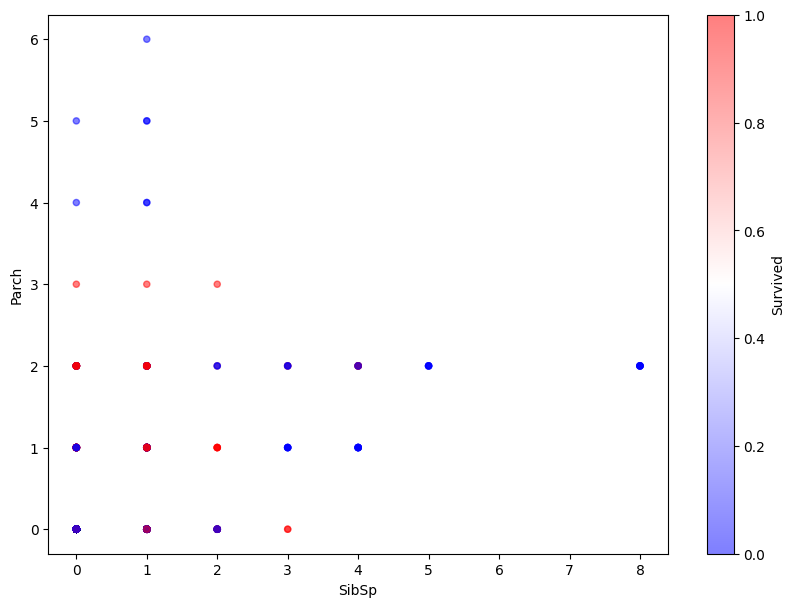

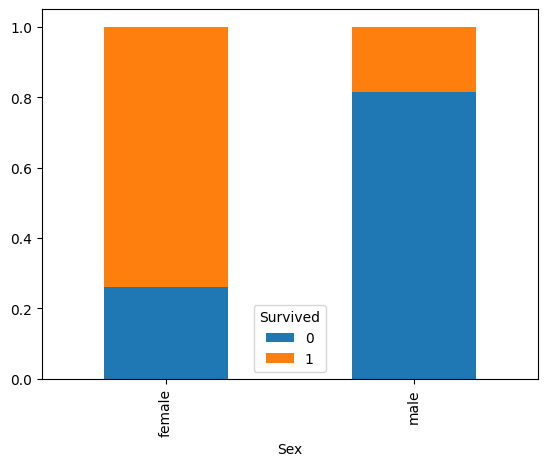

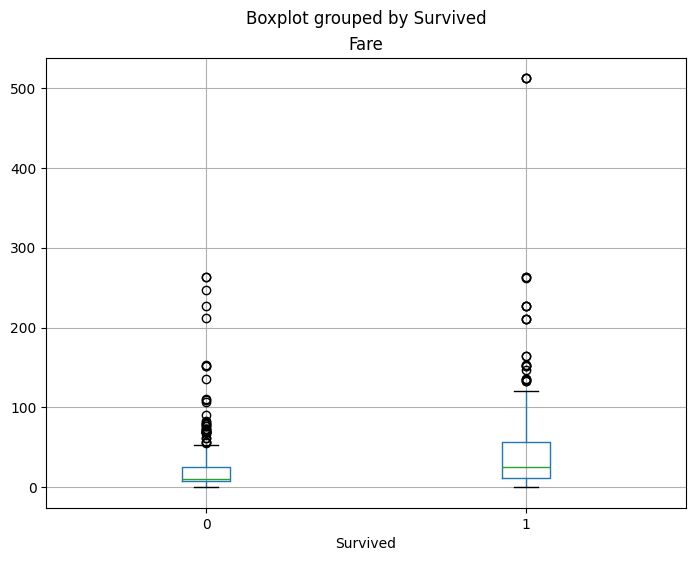

In [107]:
### ANÁLISE EXPLORATÓRIA NO CONJUNTO DE TREINAMENTO ###

# Scatter plots
titanic_train.plot(kind='scatter', x='SibSp', y='Parch', c='Survived', cmap='bwr', alpha=0.5, figsize=(10,7)) # Passageiros sozinhos e pasageiros em famílias mais numerosas tiveram menos chances de sobreviver.

# Tabela de contingência
print(pd.crosstab(titanic_train["Sex"], titanic_train["Survived"]))
pd.crosstab(titanic_train["Sex"], titanic_train["Survived"], normalize='index').plot(kind='bar', stacked=True) 
# A proporção de mulheres sobreviventes é muito maior que a de homens. Sexo pode ser um atributo importante para a predição.

# Box plots
titanic_train.boxplot(column='Fare', by='Survived', figsize=(8,6)) 
# Em média, quem pagou mais teve mais chances de sobreviver. Contudo, há uma quantidade razoável de outliers, o que pode dificultar a predição.

### Pipeline de Transformações

Após a análise exploratória, estruturamos um fluxo de pré-processamento para preparar os dados antes do treinamento do modelo. Esse fluxo é implementado através de um **pipeline de transformações**, que assegura que as mesmas etapas sejam aplicadas de forma consistente tanto no conjunto de treinamento quanto no de teste. 

O pipeline desenvolvido abaixo inclui:  
- `StandardScaler` para **Variáveis numéricas**, com o objetivo de centralizar e normalizar os valores, evitando que diferenças de escala prejudiquem o ajuste do modelo.  
- `OneHotEncoder` para **Variáveis categóricas**, convertendo categorias em variáveis binárias, o que possibilita o seu manejo matemático.  
- `PolynomialFeatures` para a feature **age**, com o intuito de capturar possíveis relações não lineares entre a idade e o target (`charges`).

No código, o pipeline é construído combinando transformações específicas para diferentes features. Para isso, utiliza-se o `ColumnTransformer`, que permite aplicar procedimentos distintos a subconjuntos de colunas do *DataFrame*.

In [47]:
### PIPELINE DE TRANFORMAÇÕES ###

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Pipeline de pré-processamento
num_age_col = ["Age"] # vamos aplicar polinômio de grau 2 só em age
num_other_cols = ["Pclass", "SibSp", "Parch", "Fare"] # outras colunas numéricas
cat_cols = ["Sex","Embarked"] # categóricas

# Pipelines de cada coluna
age_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False))  
]) # [age, age^2] escalados

num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()), 
]) # Feature scaling, subtrai a média e divide pelo desvio padrão de cada feature numérica.

cat_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder(drop='first')), 
]) # OneHotEncoding para features categoricas

pre_process_pipeline = ColumnTransformer([
        ("age", age_pipe, num_age_col),
        ("num", num_pipeline, num_other_cols),
        ("cat", cat_pipeline, cat_cols), 
    ]) # Aplica pipeline do age para a coluna age, pipeline numérico para outras colunas numéricas e pipeline categórico para colunas categóricas



### Escolha de Modelo

Após o pré-processamento e a definição do pipeline, avaliamos diferentes algoritmos de regressão.  

O objetivo aqui não é compreender em detalhe o funcionamento interno de cada modelo, mas analisá-los como **caixas-pretas** que recebem as *features* transformadas e retornam previsões para o target.  

O processo segue a mesma lógica para todos os modelos:  
1. O pipeline é treinado no conjunto de **treinamento** com `.fit()`.  
2. As previsões são obtidas sobre o conjunto de **teste** com `.predict()`.  
3. O desempenho é avaliado com métricas de erro como `mean_squared_error`, `mean_absolute_error` e o RMSE calculado a partir do MSE.  
4. A busca pelos melhores **hiperparâmetros** é realizada via `GridSearchCV`, que utiliza validação cruzada para selecionar a configuração que minimiza a função de perda escolhida.  

Os modelos considerados foram os seguintes:  
- **DummyRegressor**: usado como *baseline*, sempre prevê estatísticas simples do target (média, mediana ou quantil).  
- **Elastic Net**: modelo linear regularizado, com parâmetros `alpha` e `l1_ratio`. 
- **Random Forest Regressor**: modelo de árvores em conjunto, com parâmetros como `n_estimators` e `max_depth`.  

Além disso, foi testada uma variação do Random Forest com treinamento no **log do target**, utilizando o `TransformedTargetRegressor`. Nesse caso, o modelo aprende a prever `log(charges)`, e os resultados são reconvertidos para a escala original por meio de `np.exp`. Essa transformação desloca o foco da minimização do erro absoluto para algo mais próximo do **erro percentual**, permitindo um ajuste mais equilibrado ao longo de diferentes faixas de valores do target.  

Na comparação entre os modelos, observamos uma tendência de **redução gradual das métricas de erro consideradas**.

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

# Pipeline Completo: pré-processamento + modelo
dummy_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("dummy", DummyClassifier())
])

# Estratégias simples (feijão com arroz)
param_grid = [
    {"dummy__strategy": ["most_frequent"]},
    {"dummy__strategy": ["stratified"]},
    {"dummy__strategy": ["constant"], "dummy__constant": [1]}  # opcional: sempre predizer 1
]

# GridSearchCV (métrica: F1)
grid = GridSearchCV(
    estimator=dummy_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(titanic_train_X, titanic_train_y)

# Melhor conjunto de hiperparâmetros encontrado
best_dummy = grid.best_estimator_
print("Melhores hiperparâmetros (dummy):", grid.best_params_)
print(f"F1 médio (CV, dummy): {grid.best_score_:.2f}")

# Avaliar no conjunto de teste
pred_dummy = best_dummy.predict(titanic_test_X)
f1 = f1_score(titanic_test_y, pred_dummy)
print(f"F1 (teste, dummy): {f1:.2f}")

Melhores hiperparâmetros (dummy): {'dummy__constant': 1, 'dummy__strategy': 'constant'}
F1 médio (CV, dummy): 0.55
F1 (teste, dummy): 0.58


In [80]:
### ESCOLHA DE MODELO - LogisticRegression ###

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Pipeline Completo: pré-processamento + modelo
logist_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("logist", LogisticRegression(max_iter=5000))
])

param_grid = {
    "logist__penalty": ["l2", "l1"],
    "logist__solver": ["liblinear","saga"],
    "logist__C": [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=logist_pipeline,
    param_grid=param_grid,
    scoring="f1",   # ou 'accuracy', 'f1'
    cv=5
)

# Treinar só no conjunto de treinamento
grid.fit(titanic_train_X, titanic_train_y)

# Melhor conjunto de hiperparâmetros encontrado
best_logist = grid.best_estimator_
print("Melhores hiperparâmetros:", grid.best_params_)
print(f"F1 médio (CV, logist): {grid.best_score_:.2f}")

# Avaliar no conjunto de teste
predictions = best_logist.predict(titanic_test_X)
f1 = f1_score(titanic_test_y, predictions)
print(f"F1 (Teste, logist): {f1:.2f}")

Melhores hiperparâmetros: {'logist__C': 1, 'logist__penalty': 'l1', 'logist__solver': 'saga'}
F1 médio (CV, logist): 0.72
F1 (Teste, logist): 0.76


In [ ]:
### ESCOLHA DE MODELO - Random Forest (Classificação) ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

# Pipeline completo: pré-processamento + modelo
rf_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("randforest", RandomForestClassifier(random_state=42))
])

# Grade simples de hiperparâmetros (arroz com feijão)
param_grid = {
    "randforest__n_estimators": [100, 200],
    "randforest__max_depth": [None, 10, 20],
    "randforest__max_features": ["sqrt", "log2"],
}

# GridSearchCV (métrica: F1)
grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
)

# Treinar só no conjunto de treinamento
grid.fit(titanic_train_X, titanic_train_y)

# Melhor pipeline após a busca
best_rf = grid.best_estimator_
print("Melhores hiperparâmetros (RF):", grid.best_params_)
print(f"F1 médio (CV, RF): {grid.best_score_:.2f}")

# Avaliar no conjunto de teste
predictions = best_rf.predict(titanic_test_X)
f1 = f1_score(titanic_test_y, predictions)
print(f"F1 (teste, RF): {f1:.2f}")

Melhores hiperparâmetros (RF): {'randforest__class_weight': 'balanced', 'randforest__max_depth': 10, 'randforest__max_features': 'sqrt', 'randforest__min_samples_leaf': 1, 'randforest__n_estimators': 100}
F1 médio (CV, RF): 0.76
F1 (teste, RF): 0.78


### Visualização das Previsões

Para melhor compararmos o comportamento das previsões de cada modelo podemos construir gráficos com o auxílio da biblioteca **`matplotlib.pyplot`**.

Abaixo foram construídas duas visualizações simples:

1) O **target real** de cada amostra do **conjunto de testes** foi plotado contra o **valor previsto** por cada modelo. A linha de referência tracejada representa uma previsão perfeita.  
2) Os valores reais do **scatterplot do target `charges` vs. a feature `ages`**, sobrepostos à **nuvem de previsões** de cada modelo.

Em ambos os gráficos é possível observar que as previsões de modelos que obtiveram **menores erros após o treinamento**, de fato se **ajustaram melhor aos dados reais**.


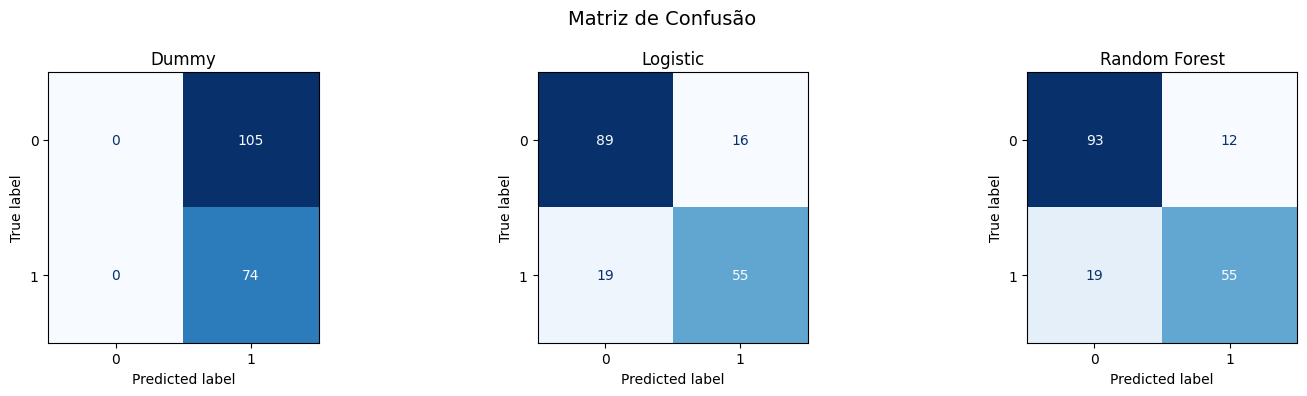

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred_dummy = best_dummy.predict(titanic_test_X)  
y_pred_logist = best_logist.predict(titanic_test_X)  
y_pred_rf = best_rf.predict(titanic_test_X)

# Matrizes de confusão
cms = {
    "Dummy": confusion_matrix(titanic_test_y, y_pred_dummy),
    "Logistic": confusion_matrix(titanic_test_y, y_pred_logist),
    "Random Forest": confusion_matrix(titanic_test_y, y_pred_rf),
}

# Plot lado a lado
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (title, cm) in zip(axes, cms.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(title)

plt.suptitle("Matriz de Confusão", fontsize=14)
plt.tight_layout()
plt.show()

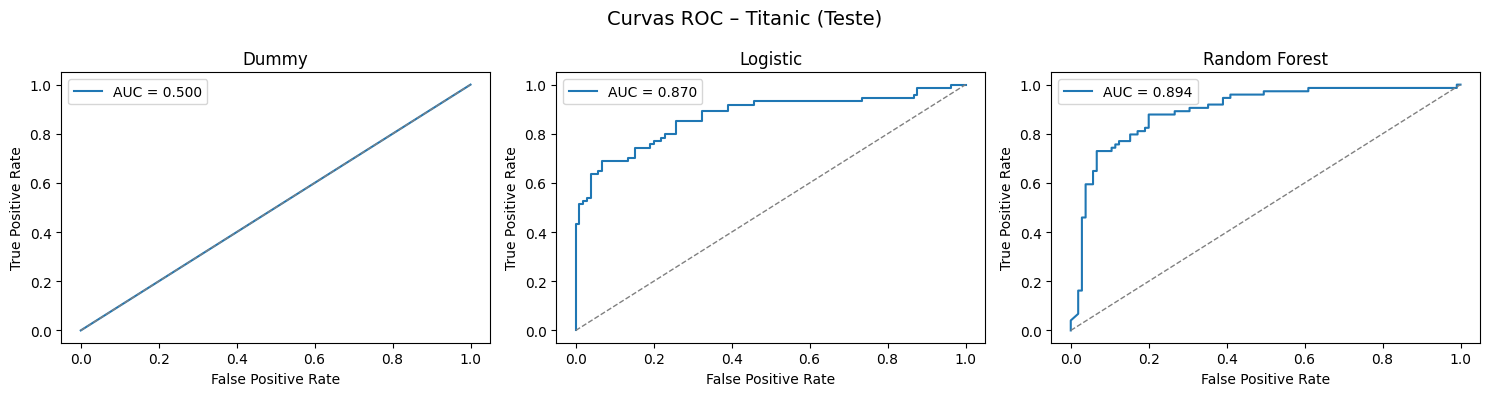

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

models = {
    "Dummy": best_dummy,
    "Logistic": best_logist,
    "Random Forest": best_rf,
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models.items()):
    y_score = model.predict_proba(titanic_test_X)[:, 1]
    fpr, tpr, _ = roc_curve(titanic_test_y, y_score)
    auc = roc_auc_score(titanic_test_y, y_score)

    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
    ax.set_title(name)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

plt.suptitle("Curvas ROC – Titanic (Teste)", fontsize=14)
plt.tight_layout()
plt.show()


### Produção

Na etapa de produção, o modelo é treinado novamente com **todos os dados disponíveis**, sem a separação treino/teste. O objetivo não é mais comparar alternativas, mas gerar um modelo final pronto para uso em previsões futuras.

É importante destacar que não se deve ajustar hiperparâmetros com o intuito de diminuir o erro proveniente do conjunto de teste, uma vez que isso pode levar a uma **perda de capacidade de generalização** do modelo frente a dados ainda não vistos.

Finalmente, em um ambiente real de produção, também é fundamental garantir o monitoramento contínuo do desempenho, realizar atualizações periódicas do modelo e tratar corretamente a entrada de novos dados para evitar degradação na qualidade das previsões.

In [103]:
### Produção ###

# Pipeline completo: pré-processamento + modelo final
prod_pipeline = Pipeline([
    ("preprocessing", pre_process_pipeline),
    ("randforest", RandomForestClassifier(
        random_state=42,
        max_depth=10,
        n_estimators=100,
        max_features="sqrt"
    ))
])

# Treinar o pipeline com todos os dados disponíveis
titanic_prod_X = titanic.drop(columns=['Survived'])
titanic_prod_y = titanic['Survived']

prod_pipeline.fit(titanic_prod_X, titanic_prod_y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['Age']),
                                                 ('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Embarked'])])),
                ('randforest',
                 RandomForestClassifier(max_depth=10, random_state=42))])